# Final linear model to estimate energy consumption

This model uses: `qc.hp1PowerInput`, `hp1.getFanSpeed`, `hp1.bottomPlateHeaterEnable`, `hp1.compressorCrankcaseHeaterEnable`
- It is trained on 4 days of data for 6 heatpumps and validated on 27 days of data.
- Based on the results we expect that the accuracy of the model is within +/- 6.9% for 99.7% of heatpumps
> Model: `EstimatedPowerConsumption` = `a` + `b` * `qc.hp1PowerInput` + `c` * `hp1.getFanspeed` + `d` *  `hp1.bottomPlateHeaterEnable` + `e` * `hp1.compressorCrankcaseHeaterEnable`  
> Where `a` = 5.150232354845286, `b` = 1.1240096401010435, `c` =  -0.04858859969715763, `d` = 150.06430841218332, `e`=40  
- The model rmse is 15.6 W when used on 27 days of validation data.
- The model is used to estimate the Power of 27 days. This Power data is integrated over time for 6 different heatpumps.  
- The resulting Energy consumption in kWh is on average 0.8% higher than the measured energy consumption with an std of 2.3%.  
- For each heatpump the model is either consistently over estimating power, or under estimating power.
- If we assume that these errors are normally distributed over heatpumps (which we cannot confirm based on 6 measurements), then we can predict energy usage up to +/- 4.6% for 95% of all heatpumps and +/- 6.9% for 99.7% of all heatpumps.
- **Next steps**:  
    - Should we place more energy meters get more certainty about our estimated energy consumption?  
    - Can we find a relation between condensator frequency, hp1.powerInput & measured power consumption? This could maybe help us identify wether a certain heatpump will consume slightly more or less energy than average, and can increase the estimates of power consumption.  

In [2]:
import pandas as pd
import numpy as np
import os
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from quatt_aws_utils.s3 import create_s3_client
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from scipy.optimize import curve_fit
import pickle

In [3]:
def train_model(X_train, y_train, positive=False):
    # Create a Linear model
    linreg = LinearRegression(fit_intercept=True, positive=positive)

    # Train the model on the training data
    linreg.fit(X_train, y_train)

    # Evaluate
    print("Coefficients = ", list(linreg.coef_) + [linreg.intercept_])
    y_train_pred = linreg.predict(X_train)
    print("rmse = ", np.sqrt(mean_squared_error(y_train, y_train_pred)))
    # print("mse = ", mean_squared_error(y_train, y_train_pred))
    print("mae = ", mean_absolute_error(y_train, y_train_pred))

    #Plot the training target against the predicted values
    plt.plot(X_train.index, y_train, X_train.index, y_train_pred)
    plt.xlabel('Time index')
    plt.ylabel('Measured and predicted values')
    plt.title('Training data: Target vs Predictions')
    plt.legend(['Measured', 'Predicted'])
    plt.show()
    return linreg

In [4]:
def evaluate_model(model, X_test, y_test):
    # Evaluate the model on the test data using mean squared error (MSE)
    y_pred = model.predict(X_test)

    # Evaluate
    print("rmse = ", np.sqrt(mean_squared_error(y_test, y_pred)))
    # print("mse = ", mean_squared_error(y_train, y_train_pred))
    print("mae = ", mean_absolute_error(y_test, y_pred))
    print("r2 = ", model.score(X_test, y_test))
    print("mean of errors = ", np.mean(y_test - y_pred))

    #Plot the training target against the predicted values
    plt.plot(X_test.index, y_test, X_test.index, y_pred)
    plt.xlabel('Time index')
    plt.ylabel('Measured and predicted values')
    plt.title('Test data: Target vs Predictions')
    plt.legend(['Measured', 'Predicted'])
    plt.show()

In [5]:
# remake test and train sets. 4 day train set and test set for rest of data
cics = [
        'CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6', 
        'CIC-0f293b7a-4524-5fc7-84b9-66f80a5a6d7c',
        'CIC-7eede49c-42c2-5b41-94aa-481dad189abf', # 8kW
        'CIC-e265a6ef-8365-5bab-a661-c23935c3c6ea' # 8kW
        ]

path_live_data = os.path.join(os.path.split(os.getcwd())[0], 'data')
print(path_live_data)

for cic in cics:
        if cic == 'CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6':
                X_train_read = pd.read_csv(os.path.join(path_live_data,'CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6-X_train-april.csv'))
                X_test_read = pd.read_csv(os.path.join(path_live_data,'CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6-X_test-april.csv'))
                X_train, X_test = train_test_split(pd.concat([X_train_read, X_test_read], ignore_index=True), test_size=0.9, shuffle=False)
                y_train_read = pd.read_csv(os.path.join(path_live_data,'CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6-y_train-april.csv'))
                y_test_read = pd.read_csv(os.path.join(path_live_data,'CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6-y_test-april.csv'))
                y_train, y_test = train_test_split(pd.concat([y_train_read, y_test_read], ignore_index=True), test_size=0.9, shuffle=False)
                energy_train_read = pd.read_csv(os.path.join(path_live_data,'CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6-energy_train-april.csv'))
                energy_test_read = pd.read_csv(os.path.join(path_live_data,'CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6energy_test-april.csv'))
                energy_train, energy_test = train_test_split(pd.concat([energy_train_read, energy_test_read], ignore_index=True), test_size=0.9, shuffle=False)
        elif cic == 'CIC-0f293b7a-4524-5fc7-84b9-66f80a5a6d7c':
                X_train_read = pd.read_csv(os.path.join(path_live_data, f'{cic}-X_train-april.csv'))
                X_test_read = pd.read_csv(os.path.join(path_live_data, f'{cic}-X_test-april.csv'))
                X_train_temp, X_test_temp = train_test_split(pd.concat([X_train_read, X_test_read], ignore_index=True), test_size=0.9, shuffle=False)
                X_train = pd.concat([X_train, X_train_temp], ignore_index=True)
                X_test = pd.concat([X_test, X_test_temp], ignore_index=True)

                y_train_read = pd.read_csv(os.path.join(path_live_data, f'{cic}-y_train-april.csv'))
                y_test_read = pd.read_csv(os.path.join(path_live_data, f'{cic}-y_test-april.csv'))
                y_train_temp, y_test_temp = train_test_split(pd.concat([y_train_read, y_test_read], ignore_index=True), test_size=0.9, shuffle=False)
                y_train = pd.concat([y_train, y_train_temp], ignore_index=True)
                y_test = pd.concat([y_test, y_test_temp], ignore_index=True)

                energy_train_read = pd.read_csv(os.path.join(path_live_data, f'{cic}-energy_train-april.csv'))
                energy_test_read = pd.read_csv(os.path.join(path_live_data, f'{cic}-energy_test-april.csv'))
                energy_train_temp, energy_test_temp = train_test_split(pd.concat([energy_train_read, energy_test_read], ignore_index=True), test_size=0.9, shuffle=False)
                energy_train = pd.concat([energy_train, energy_train_temp], ignore_index=True)
                energy_test = pd.concat([energy_test, energy_test_temp], ignore_index=True)

        else:
                X_train_read = pd.read_csv(os.path.join(path_live_data, f'{cic}-X_train-april.csv'))
                X_test_read = pd.read_csv(os.path.join(path_live_data, f'{cic}-X_test-april.csv'))
                y_train_read = pd.read_csv(os.path.join(path_live_data, f'{cic}-y_train-april.csv'))
                y_test_read = pd.read_csv(os.path.join(path_live_data, f'{cic}-y_test-april.csv'))
                energy_train_read = pd.read_csv(os.path.join(path_live_data, f'{cic}-energy_train-april.csv'))
                energy_test_read = pd.read_csv(os.path.join(path_live_data, f'{cic}-energy_test-april.csv'))
                energy_train_read['y_measured'] = y_train_read
                energy_test_read['y_measured'] = y_test_read
                energy_train_read[['qc.hp1PowerInput','hp1.getFanSpeed','hp1.temperatureOutside','hp1.bottomPlateHeaterEnable']] = X_train_read[['qc.hp1PowerInput','hp1.getFanSpeed','hp1.temperatureOutside','hp1.bottomPlateHeaterEnable']]
                energy_test_read[['qc.hp1PowerInput','hp1.getFanSpeed','hp1.temperatureOutside','hp1.bottomPlateHeaterEnable']] = X_test_read[['qc.hp1PowerInput','hp1.getFanSpeed','hp1.temperatureOutside','hp1.bottomPlateHeaterEnable']]
                energy_train_temp, energy_test_temp = train_test_split(pd.concat([energy_train_read, energy_test_read], ignore_index=True).sort_values(['time.ts']), test_size=0.9, shuffle=False)
                energy_train = pd.concat([energy_train, energy_train_temp], ignore_index=True)
                energy_test = pd.concat([energy_test, energy_test_temp], ignore_index=True)
                X_train = pd.concat([X_train, energy_train_temp[['qc.hp1PowerInput','hp1.getFanSpeed','hp1.temperatureOutside','hp1.bottomPlateHeaterEnable']]], ignore_index=True)
                X_test = pd.concat([X_test, energy_test_temp[['qc.hp1PowerInput','hp1.getFanSpeed','hp1.temperatureOutside','hp1.bottomPlateHeaterEnable']]], ignore_index=True)
                y_train = pd.concat([y_train, energy_train_temp['y_measured']], ignore_index=True)
                y_test = pd.concat([y_test, energy_test_temp['y_measured']], ignore_index=True)

y_train = y_train.iloc[:,1].combine_first(y_train.iloc[:,0])
y_test = y_test.iloc[:,1].combine_first(y_test.iloc[:,0])



/Users/noutneijmeijer/Documents/quatt_data_analysis/power-energy-calculations/data


Train and evaluate linear model for the first 4 days of data

Coefficients =  [1.1240096401010435, -0.04858859969715763, 150.06430841218332, 5.150232354845286]
rmse =  19.146657481188008
mae =  7.6225074031447635


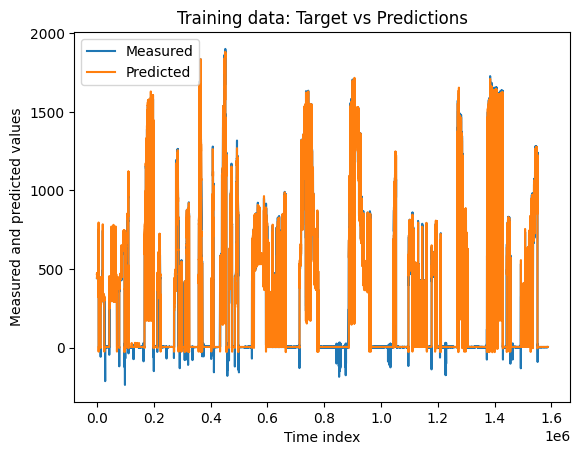

In [6]:
# Create a Linear model
regression_columns = ['qc.hp1PowerInput','hp1.getFanSpeed','hp1.bottomPlateHeaterEnable']
# regression_columns = ['qc.hp1PowerInput','hp1.getFanSpeed', 'bottomPlateHeaterEnableCalc1', 'bottomPlateHeaterEnableCalc2']

linreg = train_model(X_train[regression_columns], y_train)

# save file to ../models/energy-power-standard-model.pkl

filename = os.path.join(os.path.split(os.getcwd())[0], 'models/energy-power-standard-model.pkl')
pickle.dump(linreg, open(filename, 'wb'))


rmse =  15.623846975405248
mae =  6.443848554993267
r2 =  0.9979072675917146
mean of errors =  -0.6390257337205068


/Users/noutneijmeijer/Documents/quatt_data_analysis/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


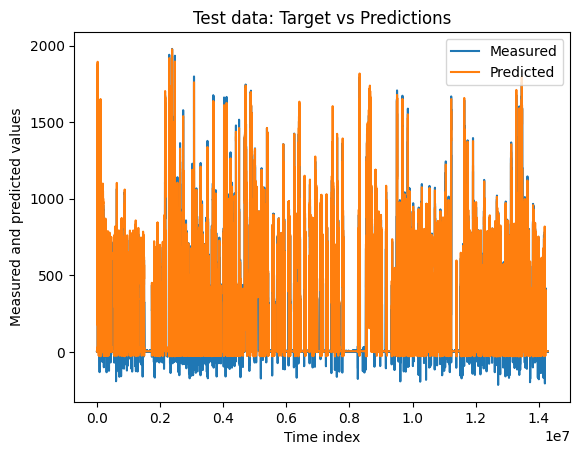

In [7]:
evaluate_model(linreg, X_test=X_test[regression_columns], y_test=y_test)

Use model to estimate energy consumption to validate model over rest of the month

In [8]:
# for each row in energy_test and energy_train set -> get measured power and predicted y
# energy_train['y_predicted'] = linreg.predict(X_train[regression_columns])
# energy_train['y_measured'] = y_train
# energy_train['qc.hp1PowerInput'] = X_train['qc.hp1PowerInput']
# energy_train['hp1.getFanSpeed'] = X_train['hp1.getFanSpeed']
# energy_train['hp1.bottomPlateHeaterEnable'] = X_train['hp1.bottomPlateHeaterEnable']
energy_test['y_predicted'] = linreg.predict(X_test[regression_columns])
energy_test['y_measured'] = y_test
energy_test['qc.hp1PowerInput'] = X_test['qc.hp1PowerInput']
energy_test['hp1.getFanSpeed'] = X_test['hp1.getFanSpeed']
energy_test['hp1.bottomPlateHeaterEnable'] = X_test['hp1.bottomPlateHeaterEnable']

# concatenate in one frame
# energy_df = pd.concat([energy_train, energy_test], ignore_index=True)
energy_df = energy_test
energy_df = energy_df.sort_values(by=['system.quattId', 'time.ts'])
energy_df = energy_df.reset_index(drop=True)

# combine 'system' and 'qc' values to one column
energy_df['system.externalElectricityMeterEnergy'] = energy_df['system.externalElectricityMeterEnergy'].combine_first(energy_df['qc.externalElectricityMeterEnergy'])
energy_df['system.externalElectricityMeterPower'] = energy_df['system.externalElectricityMeterPower'].combine_first(energy_df['qc.externalElectricityMeterPower'])
energy_df.drop(['qc.externalElectricityMeterEnergy', 'qc.externalElectricityMeterPower'], axis=1, inplace=True)


# energy_df["externalElectricityMeterDiff"] = energy_df.groupby('system.quattId', sort='time.ts')["system.externalElectricityMeterEnergy"].diff()
energy_df['timeDelta[S]'] = energy_df.groupby('system.quattId', sort='time.ts')['time.ts'].diff()/1000

# y train = measured Power + offset - pumpdutycycle  -->  measured Power = y train + pumpdutycycle - offset
def set_column_offset(row):
    if row['system.quattId'] == 'CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6':
        return -11.74
    elif row['system.quattId'] == 'CIC-0f293b7a-4524-5fc7-84b9-66f80a5a6d7c':
        return -10.07
    else:
        return 0
    
energy_df['offset'] = energy_df.apply(lambda row: set_column_offset(row), axis=1)
energy_df['measuredPower'] = energy_df['y_measured'] + energy_df['hp1.circulatingPumpDutyCycle'] - energy_df['offset'] # W
energy_df['predictedPower'] = energy_df['y_predicted'] + energy_df['hp1.circulatingPumpDutyCycle'] - energy_df['offset'] # W

energy_df['predictedEnergy[kWh]'] = (energy_df['predictedPower'] * energy_df['timeDelta[S]']) / 3600000
energy_df['measuredEnergy[kWh]'] = (energy_df['measuredPower'] * energy_df['timeDelta[S]']) / 3600000

energy_df['totalPredictedEnergy[kWh]'] = energy_df.groupby('system.quattId', sort='time.ts')['predictedEnergy[kWh]'].cumsum()
energy_df['totalMeasuredEnergy[kWh]'] = energy_df.groupby('system.quattId', sort='time.ts')['measuredEnergy[kWh]'].cumsum()

energy_df['totalMeterEnergy[kWh]'] = energy_df.groupby('system.quattId', sort='time.ts')['system.externalElectricityMeterEnergy'].apply(lambda x: x - x.iloc[0])

/var/folders/0m/6_0b79q57177vdz5tjzlnt1w0000gn/T/ipykernel_80621/487532236.py:47: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  energy_df['totalMeterEnergy[kWh]'] = energy_df.groupby('system.quattId', sort='time.ts')['system.externalElectricityMeterEnergy'].apply(lambda x: x - x.iloc[0])


In [9]:

predictedErrors = []
measuredErrors = []
cicErrors = []


for key, grp in energy_df.groupby('system.quattId'):
    grp[['time.ts','totalMeterEnergy[kWh]','totalPredictedEnergy[kWh]','totalMeasuredEnergy[kWh]']].plot(x='time.ts', figsize=(20,10), 
                                                                                                         title=f'{key}')
    plt.ylabel('Energy [kWh]')
    plt.xlabel('Time')
    # add data labels at the last point of each line
    plt.text(grp['time.ts'].iloc[-1], grp['totalMeterEnergy[kWh]'].iloc[-1], grp['totalMeterEnergy[kWh]'].iloc[-1])
    plt.text(grp['time.ts'].iloc[-1], grp['old_energyTotal[kWh]'].iloc[-1], grp['old_energyTotal[kWh]'].iloc[-1])
    
    # add title with CIC ID and percentual difference between both final data points
    plt.title(f'{key} - {round((grp["totalMeterEnergy[kWh]"].iloc[-1] - grp["old_energyTotal[kWh]"].iloc[-1])/grp["old_energyTotal[kWh]"].iloc[-1]*100, 2)}%')

    plt.xticks(grp['time.ts'], grp['time.ts'], rotation='vertical')
    

    # change x labels to be dates instead of unix timestamp
    plt.grid()
    plt.show()
    predictedErrors.append((grp['totalPredictedEnergy[kWh]'].iloc[-1] - grp['totalMeterEnergy[kWh]'].iloc[-1])/grp['totalMeterEnergy[kWh]'].iloc[-1])
    measuredErrors.append((grp['totalMeasuredEnergy[kWh]'].iloc[-1] - grp['totalMeterEnergy[kWh]'].iloc[-1])/grp['totalMeterEnergy[kWh]'].iloc[-1])
    cicErrors.append(key)

print("Predicted errors: ", predictedErrors)
print("Masured errors: ", measuredErrors)

### extra graph to show difference between old energy counter and external meter

In [9]:
energy_df['old_energy[kWh]'] = energy_df['qc.hp1PowerInput'] * energy_df['timeDelta[S]'] / 3600000
energy_df['old_energyTotal[kWh]'] = energy_df.groupby('system.quattId', sort='time.ts')['old_energy[kWh]'].cumsum()


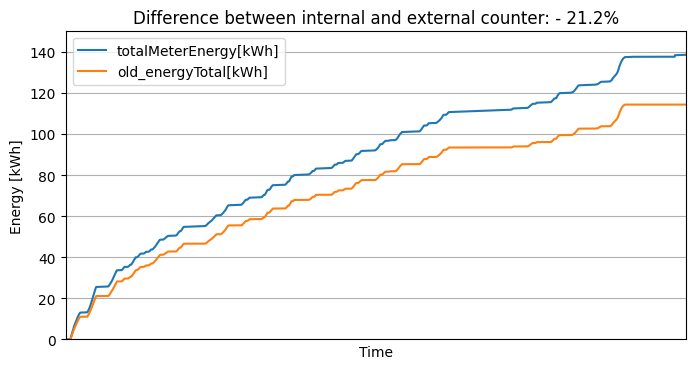

In [10]:

energy_df[energy_df['system.quattId']=='CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6'][['time.ts','totalMeterEnergy[kWh]', 'old_energyTotal[kWh]']].plot(x='time.ts', figsize=(8,4))
plt.ylabel('Energy [kWh]')
plt.xlabel('Time')
# add data labels at the last point of each line
# plt.text(energy_df[energy_df['system.quattId']=='CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6']['time.ts'].iloc[-1], 
#          energy_df[energy_df['system.quattId']=='CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6']['totalMeterEnergy[kWh]'].iloc[-1],
#          energy_df[energy_df['system.quattId']=='CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6']['totalMeterEnergy[kWh]'].iloc[-1].round(0), size=15)
# plt.text(energy_df[energy_df['system.quattId']=='CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6']['time.ts'].iloc[-1], 
#          energy_df[energy_df['system.quattId']=='CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6']['old_energyTotal[kWh]'].iloc[-1], 
#          energy_df[energy_df['system.quattId']=='CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6']['old_energyTotal[kWh]'].iloc[-1].round(0), size=15)

# add title with CIC ID and percentual difference between both final data points
plt.title(f'''Difference between internal and external counter: - {round((energy_df[energy_df['system.quattId']=='CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6']['totalMeterEnergy[kWh]'].iloc[-1] 
                            - energy_df[energy_df['system.quattId']=='CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6']['old_energyTotal[kWh]'].iloc[-1])
                                /energy_df[energy_df['system.quattId']=='CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6']['old_energyTotal[kWh]'].iloc[-1]*100, 2)}%''')
plt.xticks([])
plt.xlim(energy_df[energy_df['system.quattId']=='CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6']['time.ts'].iloc[0], energy_df[energy_df['system.quattId']=='CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6']['time.ts'].iloc[-1])
plt.ylim([0, 150])
plt.grid()
plt.show()

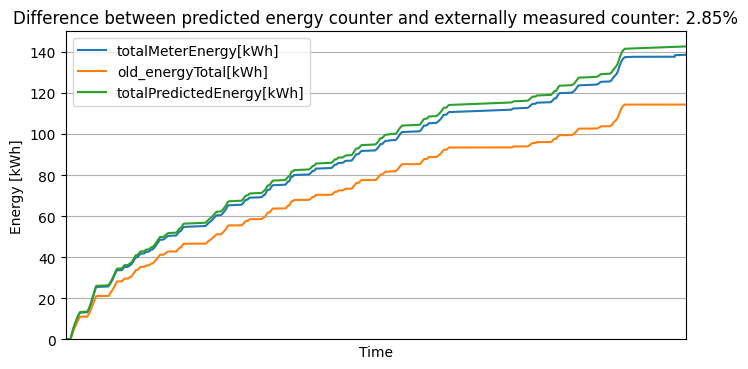

In [11]:
energy_df[energy_df['system.quattId']=='CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6'][['time.ts','totalMeterEnergy[kWh]', 'old_energyTotal[kWh]', 'totalPredictedEnergy[kWh]']].plot(x='time.ts', figsize=(8,4))
plt.ylabel('Energy [kWh]')
plt.xlabel('Time')
# add data labels at the last point of each line
# plt.text(energy_df[energy_df['system.quattId']=='CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6']['time.ts'].iloc[-1], 
#          energy_df[energy_df['system.quattId']=='CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6']['totalMeterEnergy[kWh]'].iloc[-1]-6,
#          energy_df[energy_df['system.quattId']=='CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6']['totalMeterEnergy[kWh]'].iloc[-1].round(0), size=15)
# plt.text(energy_df[energy_df['system.quattId']=='CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6']['time.ts'].iloc[-1], 
#          energy_df[energy_df['system.quattId']=='CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6']['totalPredictedEnergy[kWh]'].iloc[-1], 
#          energy_df[energy_df['system.quattId']=='CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6']['totalPredictedEnergy[kWh]'].iloc[-1].round(0), size=15)
# plt.text(energy_df[energy_df['system.quattId']=='CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6']['time.ts'].iloc[-1], 
#          energy_df[energy_df['system.quattId']=='CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6']['old_energyTotal[kWh]'].iloc[-1], 
#          energy_df[energy_df['system.quattId']=='CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6']['old_energyTotal[kWh]'].iloc[-1].round(0), size=15)

# add title with CIC ID and percentual difference between both final data points
plt.title(f'''Difference between predicted energy counter and externally measured counter: {round((energy_df[energy_df['system.quattId']=='CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6']['totalMeterEnergy[kWh]'].iloc[-1] 
                            - energy_df[energy_df['system.quattId']=='CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6']['totalPredictedEnergy[kWh]'].iloc[-1])
                                /energy_df[energy_df['system.quattId']=='CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6']['totalPredictedEnergy[kWh]'].iloc[-1]*100*-1, 2)}%''')
plt.xticks([])
plt.xlim(energy_df[energy_df['system.quattId']=='CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6']['time.ts'].iloc[0], energy_df[energy_df['system.quattId']=='CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6']['time.ts'].iloc[-1])
plt.grid()
plt.ylim([0, 150])
plt.show()